In [1]:
import pandas as pd
from gensim import models, corpora
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
from gensim.parsing.preprocessing import remove_stopwords, stem_text, strip_non_alphanum, strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_short, strip_numeric
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from semantic_text_similarity.models import WebBertSimilarity
import multiprocessing as mp
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import spatial
import parmap
import os
import swifter
from tqdm import tqdm
import sqlite3

/home/ubuntu/anaconda3/envs/econ/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [51]:
topics_index_to_name_map = {
    0: 'Agriculture, animals, food and rural affairs',
    1: 'Asylum, immigration and nationality',
    2: 'Business, industry and consumers',
    3: 'Communities and families',
    4: 'Crime, civil law, justice and rights',
    5: 'Culture, media and sport',
    6: 'Defence',
    7: 'Economy and finance',
    8: 'Education',
    9: 'Employment and training',
    10: 'Energy and environment',
    11: 'European Union',
    12: 'Health services and medicine',
    13: 'Housing and planning',
    14: 'International affairs',
    15: 'Parliament, government and politics',
    16: 'Science and technology',
    17: 'Social security and pensions',
    18: 'Social services',
    19: 'Transport',
    20: 'Others'
}
topics_name_to_index_map = {y:x for x,y in topics_index_to_name_map.items()}

def strip_short2(text):
    return strip_short(text, minsize=4)


def preprocess_text(text):
    FILTERS = [lambda x: x.lower(), strip_multiple_whitespaces, strip_tags, strip_punctuation,
                   strip_non_alphanum, strip_numeric, strip_short2]
    if text == '':
        return ''
    return preprocess_string(text, FILTERS)

def preprocess(topic):
    ret = []
    topic = topic.strip()
    
    if '|' in topic:
        topics = topic.split('|')
        t = topics[0]
        t = t.strip()
        return topics_name_to_index_map[t]
        
    return topics_name_to_index_map[topic]

In [3]:
doc2vec_model = Doc2Vec.load('../models/doc2vec/doc2vec_2010_2016_no_Others')

In [181]:
df = pd.read_csv('../data/partitions/bert_partitions_54_{}.csv'.format(2016))
df = df.drop(['Unnamed: 0'], axis=1)
df['Date'] = pd.to_datetime(df['Date'])

In [182]:
df

,Source,Date,Program Name,Time,Duration,Transcript,partitioned_transcript
0,BBC1 London,2016-06-04,Joins BBC News,01:40,260 mins,we would have seen during this weekend and the...,[p] we would have seen during this weekend and...
1,BBC1 London,2016-06-04,BBC Weekend News,12:00,15 mins,"Muhammad Ali, the boxing legend and giant of 2...","[p] Muhammad Ali, the boxing legend and giant ..."
2,BBC1 London,2016-06-04,BBC Weekend News,18:30,10 mins,# just gimme the love just gimme the love... #...,[p] # just gimme the love just gimme the love....
3,BBC1 London,2016-06-04,BBC Weekend News,22:50,20 mins,But BUT This BMT This mas his BUT This was his...,[p] But BUT This BMT This mas his BUT This was...
4,BBC1 London,2016-06-02,Joins BBC News,00:20,340 mins,It looks as though the northwest seeing the be...,[p] It looks as though the northwest seeing th...
...,...,...,...,...,...,...,...
1502,BBC1 London,2016-12-04,BBC Weekend News,22:00,20 mins,when Mark Duggan arrived at the scene at Ferry...,[p] when Mark Duggan arrived at the scene at F...
1503,BBC1 London,2016-12-30,Joins BBC News,01:20,280 mins,"By midnight, it’s probably across northern Eng...","[p] By midnight, it’s probably across northern..."
1504,BBC1 London,2016-12-30,BBC News,13:10,15 mins,Will it be happily ever after for the Mitchell...,[p] Will it be happily ever after for the Mitc...
1505,BBC1 London,2016-12-30,BBC News,18:30,15 mins,Whoop-whoop-whoop. Whoop-whoop-whoop! Do you t...,[p] Whoop-whoop-whoop. Whoop-whoop-whoop! Do y...


In [183]:
partitions = []
for index, row in df.iterrows():
    partition_string = row['partitioned_transcript']
    partition_date = row['Date']
    partition_source = row['Program Name']
    all_partitions = partition_string.split('\n')
    for partition in all_partitions:
        t = None
        if partition.startswith('[p]') and partition.endswith('[/p]'):
            t = 'p'
        else:
            t = 's'
        partitions.append((index, partition_date, partition_source, partition[3:-4], t))
partition_df = pd.DataFrame(partitions, columns=['partition_id', 'date', 'source', 'transcript', 'type'])

In [184]:
partition_df

,partition_id,date,source,transcript,type
0,0,2016-06-04,Joins BBC News,we would have seen during this weekend and th...,p
1,0,2016-06-04,Joins BBC News,"That’s it, thanks for watching.",s
2,0,2016-06-04,Joins BBC News,manage that and make sure we stay within the ...,p
3,0,2016-06-04,Joins BBC News,We start at the desk where you have the three...,p
4,0,2016-06-04,Joins BBC News,So far the inexperience is an intriguing mix ...,p
...,...,...,...,...,...
159991,1506,2016-12-30,BBC News,"The former Bishop of Liverpool, JamesJones, c...",p
159992,1506,2016-12-30,BBC News,Southern rail passengers have been warned tha...,p
159993,1506,2016-12-30,BBC News,"So on the eve of the new year, | make this ch...",p
159994,1506,2016-12-30,BBC News,"It too says it’s willing to talk but, once ag...",p


In [185]:
partition_df = partition_df.dropna(subset=['transcript'])

In [186]:
len(partition_df)

159996

In [187]:
# mask = (partition_df['date'] >= '2015-6-1') & (partition_df['date'] <= '2015-6-30')
# partition_df = partition_df.loc[mask]

In [188]:
partition_df

,partition_id,date,source,transcript,type
0,0,2016-06-04,Joins BBC News,we would have seen during this weekend and th...,p
1,0,2016-06-04,Joins BBC News,"That’s it, thanks for watching.",s
2,0,2016-06-04,Joins BBC News,manage that and make sure we stay within the ...,p
3,0,2016-06-04,Joins BBC News,We start at the desk where you have the three...,p
4,0,2016-06-04,Joins BBC News,So far the inexperience is an intriguing mix ...,p
...,...,...,...,...,...
159991,1506,2016-12-30,BBC News,"The former Bishop of Liverpool, JamesJones, c...",p
159992,1506,2016-12-30,BBC News,Southern rail passengers have been warned tha...,p
159993,1506,2016-12-30,BBC News,"So on the eve of the new year, | make this ch...",p
159994,1506,2016-12-30,BBC News,"It too says it’s willing to talk but, once ag...",p


In [189]:
bbc_files = os.listdir('../data/bbc/55/2016/transcripts')
df_list = []
for bbc_file in bbc_files:
    df_list.append(pd.read_csv('../data/bbc/55/2016/transcripts/{}'.format(bbc_file)))
website_df = pd.concat(df_list)
website_df['Date'] = pd.to_datetime(website_df['Date'])
website_df['month'] = website_df["Date"].apply(lambda x: x.month)
website_df = website_df.dropna(subset=['Transcript'])
# website_df = website_df.loc[website_df.month == 6]
website_df = website_df.drop(['Unnamed: 0'], axis=1)

In [190]:
website_df

,Source,Date,Program Name,Time,Duration,Has Transcript,Transcript,month
0,BBC.com,2016-09-01,Medical leaders condemn doctor strikes,NaN,NaN,True,Share this withEmailFacebookTwitterPinterestWh...,9
1,BBC.com,2016-09-01,Oxford state intake 'highest in decades',NaN,NaN,True,Share this withEmailFacebookTwitterPinterestWh...,9
2,BBC.com,2016-09-01,Ticks found on 'one third' of UK dogs,NaN,NaN,True,Share this withEmailFacebookTwitterPinterestWh...,9
3,BBC.com,2016-09-01,UK 'should take in 400 Calais children',NaN,NaN,True,Share this withEmailFacebookTwitterPinterestWh...,9
4,BBC.com,2016-09-01,"Be clear on Brexit aims, government told",NaN,NaN,True,Share this withEmailFacebookTwitterPinterestWh...,9
...,...,...,...,...,...,...,...,...
977,BBC.com,2016-03-31,Video 2:38\n\nBaby gorilla 'has three mums and...,NaN,NaN,True,31 March 2016 Last updated at 05:08 BST A baby...,3
978,BBC.com,2016-03-31,Video 2:41\n\n'Wide range' of talent to battle...,NaN,NaN,True,30 March 2016 Last updated at 15:27 BST Wolf H...,3
979,BBC.com,2016-03-31,Video 0:48\n\nDog 'sniffs out' diabetes danger,NaN,NaN,True,30 March 2016 Last updated at 19:20 BST A 13-y...,3
980,BBC.com,2016-03-31,Video 2:48\n\nThe Archers tackles abuse issue,NaN,NaN,True,30 March 2016 Last updated at 13:42 BST It is ...,3


In [191]:
vector = []
transcripts = partition_df.transcript.values

preprocessed_transcripts = parmap.map(preprocess_text, transcripts, pm_pbar=True)

160000it [00:04, 36867.88it/s]                            


In [192]:
vector_transcripts = parmap.map(doc2vec_model.infer_vector, preprocessed_transcripts, pm_pbar=True)
partition_df['vector'] = vector_transcripts

160000it [00:38, 4162.84it/s]                            


In [193]:
# import datetime
# articles['date'] = articles.apply(lambda x: datetime.date(x.year, x.month, x.day), axis=1)

In [194]:
website_df['vector'] = website_df.swifter.apply(lambda x: doc2vec_model.infer_vector(preprocess_text(x['Transcript'])), axis=1)

/home/ubuntu/anaconda3/envs/econ/lib/python3.7/site-packages/swifter/swifter.py:55: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`."


Pandas Apply:   0%|          | 0/11676 [00:00<?, ?it/s]

In [195]:
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime, timedelta

def predict(website_article):
    dt = website_article.Date
    partitions = partition_df.loc[partition_df['date'] == dt]
    article_vector = np.array(website_article.vector)
    article_vector = article_vector.reshape(1, 100)
    partitions_vector = partitions.vector.values
    vec = [partitions_vector[i] for i in range(len(partitions_vector))]
    vec = np.array(vec)
    sim = cosine_similarity(article_vector, vec)
    max_sim = np.max(sim)
    
    return max_sim

def predict_reverse(partition):
    dt = partition.date
    websites = website_df.loc[website_df['Date'] == dt]
    if(len(websites) == 0):
        return 0
    partition_vector = np.array(partition.vector)
    partition_vector = partition_vector.reshape(1, 100)
    websites_vector = websites.vector.values
    vec = [websites_vector[i] for i in range(len(websites_vector))]
    vec = np.array(vec)
    sim = cosine_similarity(partition_vector, vec)
    max_sim = np.max(sim)
    
    return max_sim

In [130]:
preds = []

for index, row in tqdm(website_df.iterrows(), total=len(website_df)):
    preds.append(predict(row))
    
website_df['prediction'] = preds

100%|██████████| 1507/1507 [00:03<00:00, 419.73it/s]


In [131]:
website_df

,Source,Date,Program Name,Time,Duration,Has Transcript,Transcript,Unavailable link,Unavailable reason,month,vector,prediction
0,BBC1 London,2016-06-04,Joins BBC News,01:40,260 mins,True,we would have seen during this weekend and the...,NaN,NaN,6,"[0.41039988, -0.8087966, -1.082809, 0.11838282...",0.676851
1,BBC1 London,2016-06-04,BBC Weekend News,12:00,15 mins,True,"Muhammad Ali, the boxing legend and giant of 2...",NaN,NaN,6,"[1.6226629, 1.4047338, -3.112702, -0.14350255,...",0.736808
2,BBC1 London,2016-06-04,BBC Weekend News,18:30,10 mins,True,# just gimme the love just gimme the love... #...,NaN,NaN,6,"[1.4690701, 0.62606364, -2.5017169, -1.8704599...",0.791710
3,BBC1 London,2016-06-04,BBC Weekend News,22:50,20 mins,True,But BUT This BMT This mas his BUT This was his...,NaN,NaN,6,"[0.82957196, 0.5583285, -0.96914834, -1.668441...",0.808307
4,BBC1 London,2016-06-02,Joins BBC News,00:20,340 mins,True,It looks as though the northwest seeing the be...,NaN,NaN,6,"[0.28685358, -0.50098073, -1.3161248, -0.46054...",0.659827
...,...,...,...,...,...,...,...,...,...,...,...,...
118,BBC1 London,2016-12-04,BBC Weekend News,22:00,20 mins,True,when Mark Duggan arrived at the scene at Ferry...,NaN,NaN,12,"[0.028743282, 0.23896335, -0.6509282, -1.50678...",0.628169
119,BBC1 London,2016-12-30,Joins BBC News,01:20,280 mins,True,"By midnight, it’s probably across northern Eng...",NaN,NaN,12,"[0.665591, -0.15418243, -0.5242381, -0.8218778...",0.638411
120,BBC1 London,2016-12-30,BBC News,13:10,15 mins,True,Will it be happily ever after for the Mitchell...,NaN,NaN,12,"[1.5545645, -0.059179172, -0.8091671, 1.161924...",0.661141
121,BBC1 London,2016-12-30,BBC News,18:30,15 mins,True,Whoop-whoop-whoop. Whoop-whoop-whoop! Do you t...,NaN,NaN,12,"[2.0529559, 0.03223238, -0.8035486, -1.5288234...",0.715924


In [132]:
max_sims = website_df['prediction'].values

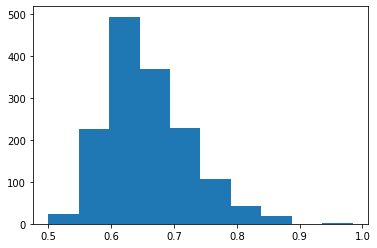

In [134]:
import matplotlib.pyplot as plt
x = website_df['Date'].values
# plt.bar(x, max_sims)
plt.hist(max_sims)
plt.savefig('max_sim_plot_2016_2.png')

In [196]:
preds = []

for index, row in tqdm(partition_df.iterrows(), total=len(partition_df)):
    preds.append(predict_reverse(row))
    
partition_df['prediction'] = preds

100%|██████████| 159996/159996 [03:00<00:00, 886.79it/s] 


In [197]:
max_sims = partition_df['prediction'].values

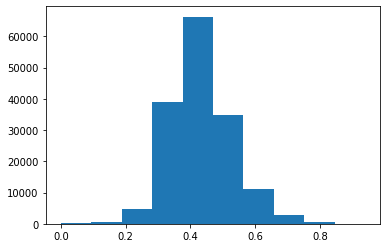

In [198]:
import matplotlib.pyplot as plt
x = partition_df['date'].values
# plt.bar(x, max_sims)
plt.hist(max_sims)
plt.savefig('max_sim_plot_2016.png')